In [1]:
import pandas as pd
from matplotlib import pyplot as plt

import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup
from pyteomics.usi import USI, proxi

from pyteomics import mgf
import pandas as pd
import os
from scipy.stats import pearsonr
import numpy as np

In [2]:
df = pd.read_csv("histone_library.tsv",sep="\t")

C:\Users\robbi\AppData\Local\Temp\ipykernel_46904\2830886835.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("histone_library.tsv",sep="\t")


In [5]:
def rewrite_proforma(input_str):
    if input_str.startswith("("):
        input_str = "!"+input_str
        input_str = input_str.replace("!(UniMod:58)","[Propionyl]-")
    input_str = input_str.replace("(UniMod:58)","[Propionyl]")
    input_str = input_str.replace("(UniMod:35)","[Oxidation]")
    input_str = input_str.replace("(UniMod:1289)","[Butyryl]")
    input_str = input_str.replace("(UniMod:1)","[Acetyl]")
    
    return input_str

df["somewhat_proforma"] = df["PeptideGroupLabel"].apply(rewrite_proforma)

In [6]:
spectra_location = "spectra/"
all_df = []

for f in os.listdir(spectra_location):
    mgf_file = os.path.join(spectra_location,f)
    # Extract the single spectrum

    # Parse the MGF file
    spectra = mgf.read(mgf_file)
    
    spectrum = next(spectra)
    
    # Create a DataFrame from the m/z and intensity values
    df_msfragger = pd.DataFrame(spectrum['m/z array'], columns=['m/z'])
    df_msfragger['intensity'] = spectrum['intensity array']
    df_msfragger['title'] = spectrum["params"]["title"].replace("NH2-","").replace("-COOH","").replace("<56.0262 of K>","[Propionyl]").replace("<15.9949 of M>","[Oxidation]").replace("<70.0419 of K>","[Butyryl]").replace("42.0106","[Acetyl]").replace("56.0262-","[Propionyl]-").split(" ")[1]
    df_msfragger['charge'] = list(spectrum['params']['charge'])[0]

    all_df.append(df_msfragger)
    
df_msfragger = pd.concat(all_df)

In [10]:
def get_correlation(annotations,mz,intensity):
    mzs_new = [i for annotation, i in zip(annotations,mz) if len(annotation.fragment_annotations) > 0]
    intensities_new = [i for annotation, i in zip(annotations,intensity) if len(annotation.fragment_annotations) > 0]
    annotations_new = [str(annotation.fragment_annotations[0]) for annotation in annotations if len(annotation.fragment_annotations) > 0]
    return mzs_new, intensities_new, annotations_new

def calculate_spectral_angle(true, pred, epsilon=1e-7):
    """
    Calculate square root normalized spectral angle.
 
    See https://doi.org/10.1074/mcp.O113.036475.
    """
    pred_norm = pred / max(np.linalg.norm(pred), epsilon)
    true_norm = true / max(np.linalg.norm(true), epsilon)
    spectral_angle = 1 - (2 * np.arccos(np.dot(pred_norm, true_norm)) / np.pi)
    return spectral_angle
 
def get_correlation_values(values1_mz, values1_intensity, values1_annotations, values2_mz, values2_intensity, values2_annotations):
    # Creating dataframes
    df1 = pd.DataFrame({'mz': values1_mz, 'intensity': values1_intensity, 'annotation': values1_annotations})
    df2 = pd.DataFrame({'mz': values2_mz, 'intensity': values2_intensity, 'annotation': values2_annotations})

    # Strip the tolerance from the annotations
    df1['annotation'] = df1['annotation'].apply(lambda x: x.split('/')[0])
    df2['annotation'] = df2['annotation'].apply(lambda x: x.split('/')[0])

    # Merging dataframes on annotations after stripping tolerance
    merged_df = pd.merge(df1, df2, on='annotation', how='outer', suffixes=('_1', '_2'))
    merged_df.fillna(0.0,inplace=True)
    
    # Calculating Pearson correlation
    pearson_corr, _ = pearsonr(merged_df['intensity_1'], merged_df['intensity_2'])
    
    # Intensities from the merged dataframe
    intensities_1 = merged_df['intensity_1'].to_numpy()
    intensities_2 = merged_df['intensity_2'].to_numpy()
    
    spectral_angle = calculate_spectral_angle(intensities_1, intensities_2)
    
    return pearson_corr, spectral_angle

spec_angle_all = []
pearson_r_all = []

for peptide in set(list(df_msfragger["title"])):
    sub_df_msfragger = df_msfragger[df_msfragger["title"] == peptide]
    msfragger_mz = sub_df_msfragger['m/z']
    msfragger_intensity = sub_df_msfragger['intensity']
    msfragger_charge = sub_df_msfragger["charge"].iloc[0]

    library_df = df[(df["somewhat_proforma"] == peptide) & (df["PrecursorCharge"] == msfragger_charge)]
    library_intensity = library_df["LibraryIntensity"]
    library_mz = library_df["ProductMz"]

    
    spectrum_obj1 = sus.MsmsSpectrum(
        peptide,
        0.0,
        2,
        library_mz,
        library_intensity,
        #peptide=peptide
    )
    spectrum_obj1.annotate_proforma(
        peptide,
        5,
        "ppm")
    
    spectrum_obj2 = sus.MsmsSpectrum(
        peptide,
        0.0,
        2,
        msfragger_mz,
        msfragger_intensity,
        #peptide=peptide
    )
    spectrum_obj2.annotate_proforma(
        peptide,
        30,
        "ppm")
    
    mzs_new, intensities_new, annotations_new = get_correlation(spectrum_obj1.annotation,spectrum_obj1.mz,spectrum_obj1.intensity)
    
    if len(mzs_new) == 0:
        continue
    
    spectrum_obj1 = sus.MsmsSpectrum(
        peptide,
        0.0,
        2,
        mzs_new,
        intensities_new,
    )
    spectrum_obj1.annotate_proforma(
        peptide,
        5,
        "ppm")
    
    mzs_new2, intensities_new2, annotations_new2 = get_correlation(spectrum_obj2.annotation,spectrum_obj2.mz,spectrum_obj2.intensity)

    spectrum_obj2 = sus.MsmsSpectrum(
        peptide,
        0.0,
        2,
        mzs_new2,
        intensities_new2,
    )
    
    spectrum_obj2.annotate_proforma(
        peptide,
        30,
        "ppm")
    
    pearson_r, spec_angle = get_correlation_values(mzs_new, intensities_new, annotations_new, mzs_new2, intensities_new2, annotations_new2)
    spec_angle_all.append(spec_angle)
    pearson_r_all.append(pearson_r)

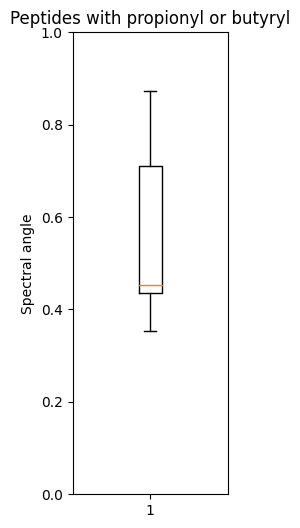

In [8]:
import matplotlib.pyplot as plt

# Create a boxplot
fig, ax = plt.subplots(figsize=(2, 6))
plt.boxplot(spec_angle_all, vert=True)
plt.title('Peptides with propionyl or butyryl')
plt.ylabel('Spectral angle')
plt.ylim(0,1.0)
plt.show()

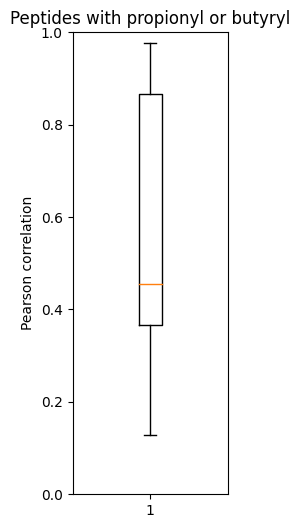

In [9]:
# Create a boxplot
fig, ax = plt.subplots(figsize=(2, 6))
plt.boxplot(pearson_r_all, vert=True)
plt.title('Peptides with propionyl or butyryl')
plt.ylabel('Pearson correlation')
plt.ylim(0,1.0)
plt.show()